In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import seaborn as sns
sns.set(style='dark', font_scale=1.3)

import warnings
warnings.filterwarnings('ignore')

# <a href="https://mipt-stats.gitlab.io/courses/ad_mipt.html">Phystech@DataScience</a>


(a)  Cкачаем [датасет](https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate) о предсказании пульсаров.





Пульсары &mdash; это космические объекты, излучающие в различных диапазонах длины волны. Согласно современным астрофизическим теориям, пульсары представляют собой вращающиеся нейтронные звезды, обладающие магнитным полем, наклоненным относительно оси вращения.

Пульсары представляют значительный научный интерес. Поэтому есть потребность в автоматическом обнаружении интересных объектов для ускорения процесса изучения. На практике почти все обнаружения вызваны радиочастотными помехами и шумом, что затрудняет поиск достоверных сигналов. В последнее время для автоматического обнаружения пульсаров начали применять машинное обучение. Актуальная задача сегодня &mdash; бинарная классификация объектов-кандидатов на предмет того, являются ли они пульсарами.

В используемом датасете есть как примеры ложных обнаружений, так и примеры реальных пульсаров, подтвержденные учеными. Данные получены в результате [The High Time Resolution Universe Pulsar Survey I](https://arxiv.org/abs/1006.5744).

Мы будем работать только с файлом `pulsar_data_train.csv`.

In [2]:
data = pd.read_csv("pulsar_data_train.csv")

Сигнал от пульсаров представляет собой периодические импульсы.

Для описания объекта используется integrated profile (интегральный профиль) &mdash; агрегирование сигнала за разные периоды вращения (<a target="_blank" href="http://ipta.phys.wvu.edu/files/student-week-2017/IPTA2017_KuoLiu_pulsartiming.pdf">ссылка</a>, слайд 11). У всех пульсаров разные интегральные профили, и обычно эта характеристика мало меняется во времени.
В данном датасете интегральный профиль также усреднен по частоте.

Кроме того, импульс приходит в разное время на разных частотах. Задержка от частоты к частоте вызвана наличием ионизированной межзвездной среды и называется дисперсией. Не путать с дисперсией в теории вероятностей.

С дисперсией связана еще одна характеристика объекта &mdash; DM-SNR кривая. Подробнее об этой характеристике можно почитать <a target="_blank" href="https://arxiv.org/pdf/1005.5068.pdf#:~:text=period-DM%20diagram%3B%20good%20agreement,pulsars%20in%20their%20candidate%20plots.)">в специализированных материалах</a>.

Обе характеристики, integrated profile и DM-SNR кривая, представляют собой одномерные функции.
При создании датасета значения функций были посчитаны в конечном количестве $n$ точек.
Фактически, были получены реализации выборки двух случайных величин.

Пусть $P = (p_1, \ldots p_n)$ &mdash; массив значений integrated profile.
Для него можно посчитать следующие статистики:

1.   Выборочное среднее $\bar p = \frac{1}{n}\sum \limits_{i=1}^n p_i$;
2.   Выборочное стандартное отклонение $\sqrt{\frac{1}{n}\sum \limits_{i=1}^n (p_i - \bar p)^2}$;
3. Выборочный коэффициент асимметрии (skewness);
4. Выборочный коэффициент эксцесса (kurtosis).

Для $D = (d_1, \ldots d_n)$, массива значений DM-SNR, аналогично.

Именно эти значения по массивам $P$ и $D$ являются признаками в данном датасете.

Про коэффициенты эксцесса и асимметрии можно посмотреть <a target="_blank" href="https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%8D%D0%BA%D1%81%D1%86%D0%B5%D1%81%D1%81%D0%B0">здесь</a> и <a target="_blank" href="https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B0%D1%81%D0%B8%D0%BC%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%B8">здесь</a>, формулы для выборочных коэффициентов асимметрии и эксцесса можно найти в английской версии этих статей.

<a target="_blank" href="https://arxiv.org/pdf/1603.05166.pdf">Статья</a> с подробным описанием процесса генерации данных.










In [3]:
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                12528 non-null  float64
 1    Standard deviation of the integrated profile  12528 non-null  float64
 2    Excess kurtosis of the integrated profile     10793 non-null  float64
 3    Skewness of the integrated profile            12528 non-null  float64
 4    Mean of the DM-SNR curve                      12528 non-null  float64
 5    Standard deviation of the DM-SNR curve        11350 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           12528 non-null  float64
 7    Skewness of the DM-SNR curve                  11903 non-null  float64
 8   target_class                                   12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


В этом датасете в некоторых столбцах есть пропуски в данных. Об этом говорит то, что значение Non-Null Count в таблице выше не равно количеству строк для некоторых столбцов. Чтобы не усложнять себе жизнь, пока просто не будем брать эти столбцы для анализа.

Столбец `target_class` отвечает за целевую переменную — индикатор того, является ли объект пульсаром.

In [5]:
needed_columns = [' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve']  # используем только эти столбцы

X = data[needed_columns]

In [6]:
y = data['target_class']

(b) Проведите визуальный анализ данных. Например, можете построить оценки плотности по каждому признаку
отдельно для каждого класса. Какие признаки лучше всего разделяют классы?

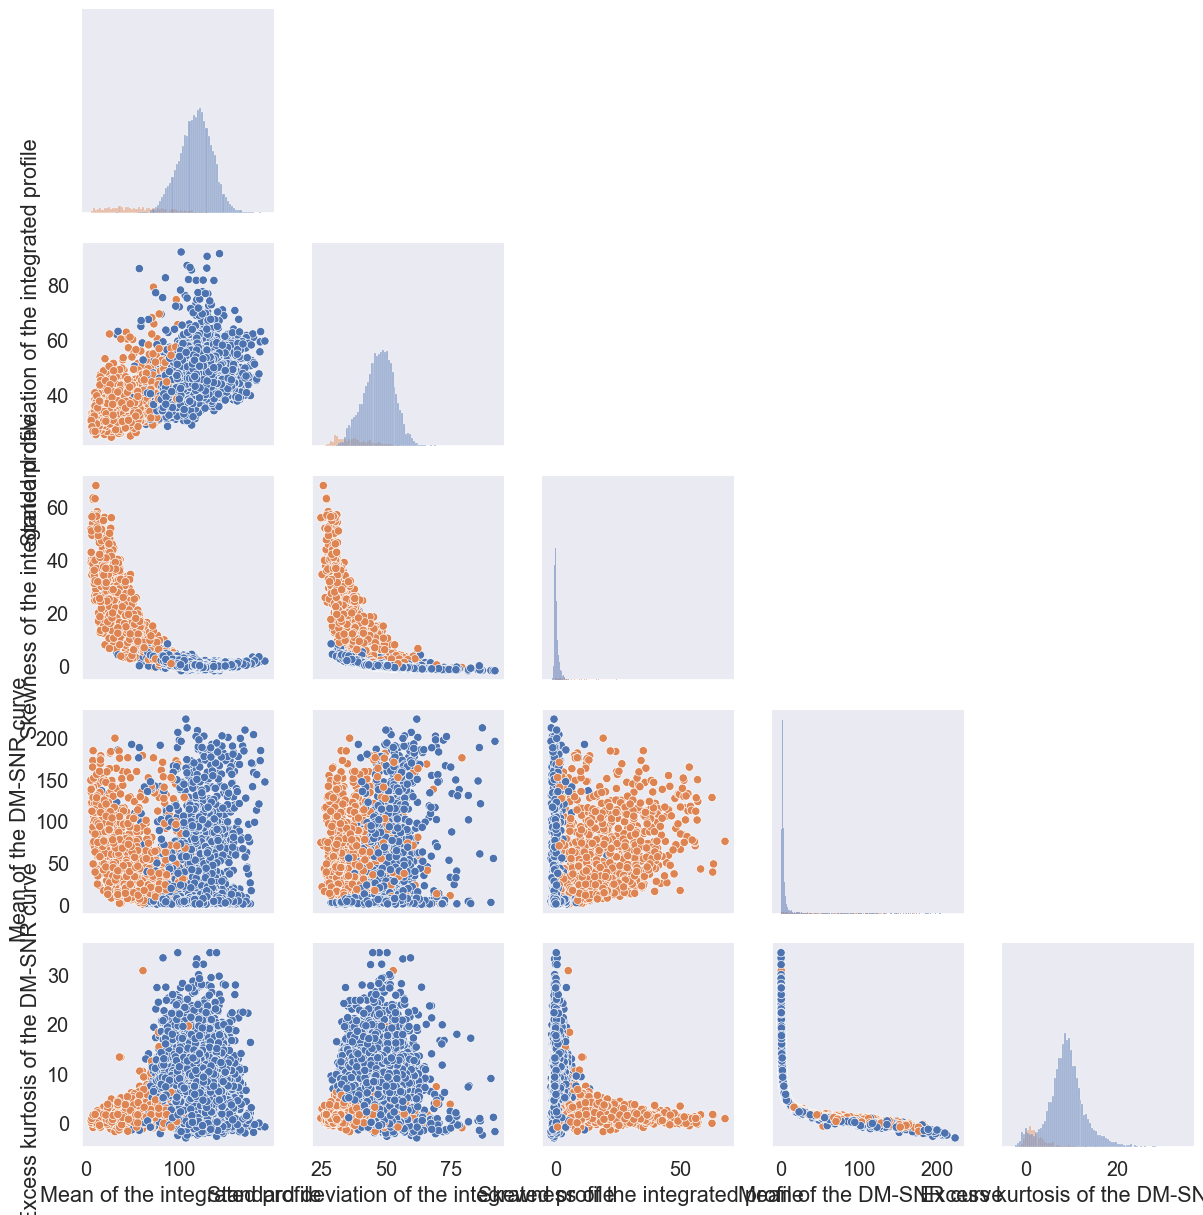

In [8]:
g =sns.PairGrid(data,hue = 'target_class',vars=needed_columns,corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)

**Вывод** Классы по признакам визуально различимы. Ожидаем сильную модель

У признаков должен быть одинаковы масштаб. Почему? Как этого добиться?

**Ответ:** Для логистической регрессии в случае линейно разделимых классов необходима регуляризация. В противном случае разделяющая плоскость не может быть строго определена

В sklearn используем [sklearn.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [106]:
# испольузем pipe для совместного обучения imputer, scaler и логистической регрессии 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

pipe = Pipeline([('imputer',KNNImputer()), ('scaler', StandardScaler()), ('LR', LogisticRegression())])

В данных есть пропуски. Сколько их? Уберите данные с пропусками.

In [107]:
data.isna().sum()

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
scores                                              0
scores_bucket                                       0
dtype: int64

(c) Добавьте  свободный член.   Разделите выборку на обучающую и тестовую часть случайным образом в соотношении 4:1.

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(d)  Обучите логистическую регрессию по всем признакам.  

In [109]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('LR', LogisticRegression())])

Напечатайте коэффициенты модели. Сделайте выводы.

In [111]:
pipe['LR'].coef_,pipe['LR'].intercept_

(array([[-1.43187406,  0.55632414,  3.24676878, -0.32732089, -1.27768189]]),
 array([-3.59200336]))

Самый мощный признак - Excess kurtosis of the integrated profile. Это ожидаемо. Наблюдали разделяющую силу признака на графиках распределений.

(e) Для  объектов из тестовой выборки оцените вероятность того, что это пульсар и сделайте предсказания. Насколько точны
ваши прогнозы?
Реализуйте известные вам метрики качества и выведите их значения. Какие метрики вам кажутся важнее в данной задаче?


In [113]:
predict_y_test = pipe.predict_proba(X_test)

0.9620727848407119

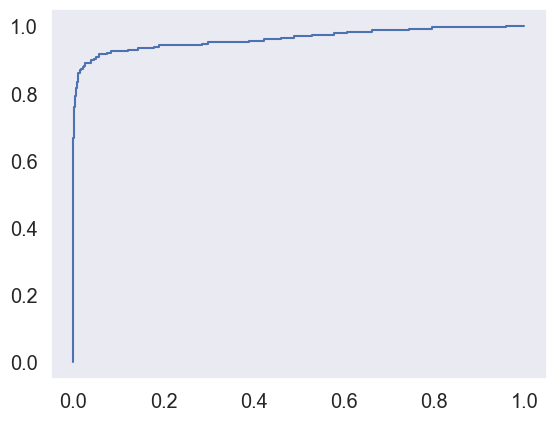

In [114]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, predict_y_test[:,1])
plt.plot(fpr,tpr)
roc_auc_score(y_test.values, predict_y_test[:,1])

Модель - сильная :) Разделяющая сила модели позволяет найти бакеты с очень высокой вероятностью обнаружения пульсара.

Визуализируем gain chart

In [65]:
data['scores'] = pipe.predict_proba(data[needed_columns])[:,1]
data['scores_bucket'] = pd.qcut(data['scores'],q=10)


In [66]:
buckets = data.groupby('scores_bucket')[['scores','target_class']].mean()

In [67]:
buckets

,scores,target_class
scores_bucket,,
"(-0.00099829, 0.00173]",0.000906,0.003192
"(0.00173, 0.00343]",0.002576,0.004789
"(0.00343, 0.00525]",0.004293,0.002394
"(0.00525, 0.00758]",0.006348,0.004792
"(0.00758, 0.0108]",0.009048,0.009577
"(0.0108, 0.0155]",0.012923,0.006385
"(0.0155, 0.0233]",0.019071,0.015974
"(0.0233, 0.0408]",0.030690,0.017558
"(0.0408, 0.142]",0.069391,0.063049


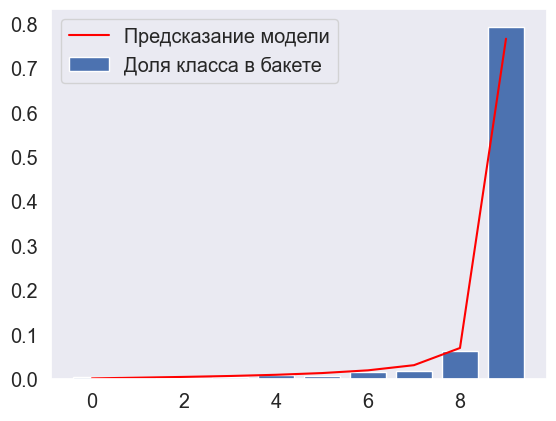

In [79]:
plt.plot(range(len(buckets['scores'].values)),buckets['scores'].values,color='red',label='Предсказание модели')
plt.bar(x=range(len(buckets['target_class'])),height=buckets['target_class'].values,label='Доля класса в бакете')
plt.legend()
None